## <font color='darkblue'>Problem - Heart Failure Prediction Dataset</font>
([Kaggle link](https://www.kaggle.com/fedesoriano/heart-failure-prediction/discussion)) From this task, we have 11 clinical features for predicting heart disease events. Below we will follow this post <b><a href='https://www.kaggle.com/kaanboke/beginner-friendly-catboost-with-optuna'>Beginner Friendly CATBOOST with OPTUNA</a></b> to introduce the steps in applying ML in this problem.
* <font size='3ptx'><b><a href='#sect1'>Step1 - Collecting raw data</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>Step2 - Exploratory Data Analysis</a></b></font>
* <font size='3ptx'><b><a href='#sect3'>Step3 - Feature Extraction/Engineering</a></b></font>
* <font size='3ptx'><b><a href='#sect4'>Step4 - Model Selection</a></b></font>
* <font size='3ptx'><b><a href='#sect5'>Step5 - Model Evaluation</a></b></font>

In [1]:
#!pip install cufflinks
#!pip install catboost
#!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import matplotlib.pyplot as plt
import warnings
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import plotly 
import plotly.express as px

from IPython.display import Image

warnings.filterwarnings("ignore")
pd.set_option('max_columns',100)
pd.set_option('max_rows',900)
pd.set_option('max_colwidth',200)

RANDOM_STATE = 42

### <font color='darkgreen'>Understand the task</font>
What Problem We Have and Which Metric to Use?
* Based on the data and data dictionary, We have <b>a classification problem</b>.
* We wil <b>make classification on the target variable `Heart Disease`</b>
* And we will build a model to get best calssification possible on the target variable.

<a id='sect1'></a>
## <font color='darkblue'>Step1 - Collect raw data</font>
* <font size='3ptx'><b><a href='#sect1-1'>Missing values</a></b></font>
* <font size='3ptx'><b><a href='#sect1-2'>Study Columns</a></b></font>
<br/>

From Kaggle, you don't have to collect raw data by youself. You can download the dataset from [this link](https://www.kaggle.com/fedesoriano/heart-failure-prediction) directly. I already downloaded it (<font color='olive'>heart.csv</font>) and now we can load this dataset in DataFrame as below:

In [3]:
raw_df = pd.read_csv('datas/heart.csv')
raw_df.sample(n=5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
252,61,M,ASY,125,292,0,ST,115,Y,0.0,Up,0
569,55,M,ASY,158,217,0,Normal,110,Y,2.5,Flat,1
22,49,F,ATA,124,201,0,Normal,164,N,0.0,Up,0
216,39,M,ASY,110,280,0,Normal,150,N,0.0,Flat,1
764,41,F,NAP,112,268,0,LVH,172,Y,0.0,Up,0


We total have 12 columns and the target column is `HeartDisease` (1 or 0). The details of them are as below:
1. <b>Age:</b> Age of the patient \[years]
2. <b>Sex</b>: Sex of the patient \[M: Male, F: Female]
3. <b>ChestPainType</b>: \[TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. <b>RestingBP</b>: Resting blood pressure \[mm Hg]
5. <b>Cholesterol</b>: Serum cholesterol \[mm/dl]
6. <b>FastingBS</b>: Fasting blood sugar \[1: if FastingBS > 120 mg/dl, 0: otherwise]
7. <b>RestingECG</b>: Resting electrocardiogram results \[Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. <b>MaxHR</b>: Maximum heart rate achieved \[Numeric value between 60 and 202]
9. <b>ExerciseAngina</b>: Exercise-induced angina \[Y: Yes, N: No]
10. <b>Oldpeak</b>: ST \[Numeric value measured in depression] (
11. <b>ST_Slope</b>: The slope of the peak exercise ST segment \[Up: upsloping, Flat: flat, Down: downsloping]
12. <b>HeartDisease</b>: Output class \[1: heart disease, 0: Normal]

Reference: https://www.kaggle.com/fedesoriano/heart-failure-prediction

<a id='sect1-1'></a>
### <font color='darkgreen'>Missing values</font>
<font size='3ptx'><b>Data Cleaning is the process of finding and correcting the inaccurate/incorrect data that are present in the dataset.</b></font> One such process needed is to do something about the values that are missing in the dataset. In real life, many datasets will have many missing values, so dealing with them is an important step.

In [4]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(raw_df)

,Missing_Number,Missing_Percent
HeartDisease,0,0.0
ST_Slope,0,0.0
Oldpeak,0,0.0
ExerciseAngina,0,0.0
MaxHR,0,0.0
RestingECG,0,0.0
FastingBS,0,0.0
Cholesterol,0,0.0
RestingBP,0,0.0
ChestPainType,0,0.0


Good news is that we don't have any missing value in our dataset.

<a id='sect1-2'></a>
### <font color='darkgreen'>Study Columns</font>
Here we have total 5 columns with type as integer; 6 columns with type as others.

In [5]:
numerical= raw_df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns
categorical = raw_df.select_dtypes('object').columns

print(f'Numerical Columns:  {raw_df[numerical].columns}')
print(f'Categorical Columns: {raw_df[categorical].columns}')

Numerical Columns:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')
Categorical Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [6]:
raw_df[categorical].nunique()

Sex               2
ChestPainType     4
RestingECG        3
ExerciseAngina    2
ST_Slope          3
dtype: int64

For those 6 columns, they seem to have small and limit options. We can possibly treat them as categorical features.

<a id='sect2'></a>
## <font color='darkblue'>Step2 - Exploratory Data Analysis</font>
* <font size='3ptx'><b><a href='#sect2-1'>Target Variable</a></b></font>
* <font size='3ptx'><b><a href='#sect2-2'>Numerical Features</a></b></font>
* <font size='3ptx'><b><a href='#sect2-3'>Categorical Features</a></b></font>
<br/>

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations. ([wiki](https://en.wikipedia.org/wiki/Exploratory_data_analysis))

<a id='sect2-1'></a>
### <font color='darkgreen'>Target Variable</font>
* Almost 55% of the patients had a heart disease.
* 508 patient had a heart disease.
* Almost 45% of patients didn't have a heart disease.
* 410 patient didn't have a heart disease.

In [7]:
y = raw_df['HeartDisease']
print(f'Percentage of patient had a HeartDisease:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} patient)\nPercentage of patient did not have a HeartDisease: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} patient)')

Percentage of patient had a HeartDisease:  55.34 %  --> (508 patient)
Percentage of patient did not have a HeartDisease: 44.66  %  --> (410 patient)


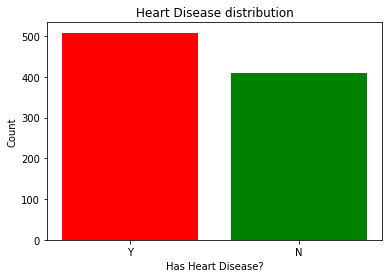

In [8]:
y_count = raw_df[raw_df['HeartDisease']==1].shape[0]
n_count = raw_df[raw_df['HeartDisease']==0].shape[0]
heat_disease_values = [y_count, n_count]
x = np.arange(len(heat_disease_values))
plt.bar(x, heat_disease_values, color=['red', 'green'])
plt.xticks(x, ['Y', 'N'])
plt.xlabel('Has Heart Disease?')
plt.ylabel('Count')
plt.title('Heart Disease distribution')
plt.show()

There is a little imblanace but nothing in the disturbing level. <b>We can use 'accuracy' metric as our evaluation metric.</b> (<a href='https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/'>How to deal with imbalanced dataset</a>)

<a id='sect2-2'></a>
### <font color='darkgreen'>Numerical Features</font>

In [9]:
raw_df[numerical].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000


In [10]:
#raw_df[numerical].iplot(kind='hist');

In [11]:
raw_df[numerical].iplot(kind='histogram', subplots=True, bins=50)

In [12]:
# This is our threshold-limit to evaluate skewness.
# Overall below abs(1) seems acceptable for the linear models. 
skew_limit = 0.75 
skew_vals = raw_df[numerical].drop('FastingBS', axis=1).skew()
skew_cols= skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols

Oldpeak    1.022872
dtype: float64

Here we find that column `Oldpeak` is a bit higher in skew evaluation. You may want to check if the dataset is polluted or not:

In [13]:
Image(url= "https://github.com/johnklee/ml_articles/raw/master/kaggle/Heart_Failure_Prediction_Dataset/Images/4.PNG")

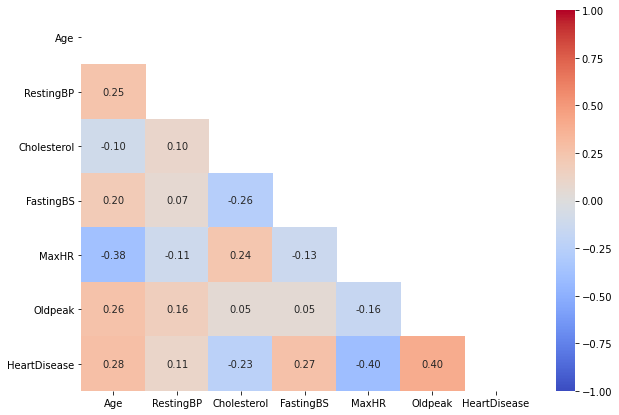

In [14]:
numerical1= raw_df.select_dtypes('number').columns
matrix = np.triu(raw_df[numerical1].corr())
fig, ax = plt.subplots(figsize=(10, 7)) 
sns.heatmap(
    raw_df[numerical1].corr(),
    annot=True, fmt= '.2f',
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',mask=matrix, ax=ax);

* Based on the matrix, we can observe weak level correlation between the numerical features and the target variable
* `Oldpeak` (depression related number) has a positive correlation with the heart disease.
* Maximum heart rate has negative correlation with the heart disease.
* Interestingly cholesterol has negative correlation with the heart disease.

<a id='sect2-3'></a>
### <font color='darkgreen'>Categorical Features</font>

In [15]:
raw_df[categorical].head()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up


#### Gender and Heart Disease

In [16]:
gender_percentage_data_has_hd = [
    raw_df[raw_df["Sex"]=="F"]["HeartDisease"].sum(),
    raw_df[raw_df["Sex"]=="M"]["HeartDisease"].sum()]
gender_percentage_data_no_hd = [
    raw_df[(raw_df["Sex"]=="F") & (raw_df["HeartDisease"]==0)].shape[0],
    raw_df[(raw_df["Sex"]=="M") & (raw_df["HeartDisease"]==0)].shape[0]]
#print (f'A female person has a probability of {round(raw_df[raw_df["Sex"]=="F"]["HeartDisease"].mean()*100,2)} % have a HeartDisease')
#print (f'A male person has a probability of {round(raw_df[raw_df["Sex"]=="M"]["HeartDisease"].mean()*100,2)} % have a HeartDisease')

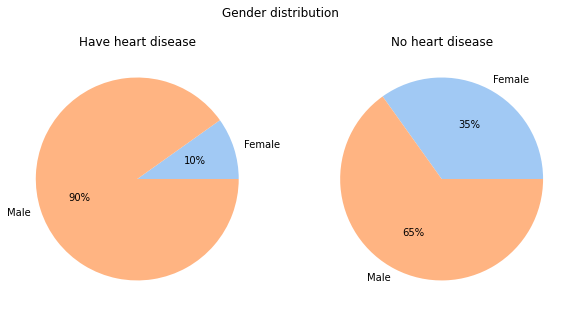

In [17]:
labels = ['Female', 'Male']

# Define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

# Create pie chart
plt.rcParams['figure.figsize'] = [10, 5]
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.pie(gender_percentage_data_has_hd, labels=labels, colors=colors, autopct='%.0f%%')
ax1.set_title('Have heart disease')
ax2.pie(gender_percentage_data_no_hd, labels=labels, colors=colors, autopct='%.0f%%')
ax2.set_title('No heart disease')

fig.suptitle('Gender distribution')
fig.show()

In [18]:
fig = px.histogram(raw_df, x="Sex", color="HeartDisease",width=400, height=400)
fig.show()

Bad news guys.... Men are almost 2.44 times more likely have a heart disease than women.

#### Chest Pain Type and Heart Disease

In [19]:
raw_df.groupby('ChestPainType')['HeartDisease'].mean().sort_values(ascending=False)

ChestPainType
ASY    0.790323
TA     0.434783
NAP    0.354680
ATA    0.138728
Name: HeartDisease, dtype: float64

In [20]:
fig = px.histogram(raw_df, x="ChestPainType", color="HeartDisease",width=400, height=400)
fig.show()

* We can observe clear differences among the chest pain type.
* Person with `ASY`: Asymptomatic chest pain has almost 6 times more likely have a heart disease than person with `ATA` Atypical Angina chest pain.

<a id='sect3'></a>
## <font color='darkblue'>Step3 - Feature Extraction/Engineering</font>
* <font size='3ptx'><b><a href='#sect3-1'>Category features</a></b></font>
* <font size='3ptx'><b><a href='#sect3-2'>Normalization</a></b></font>
* <font size='3ptx'><b><a href='#sect3-3'>Train/Test Split</a></b></font>
* <font size='3ptx'><b><a href='#sect3-4'>Build pipeline</a></b></font>
* <font size='3ptx'><b><a href='#sect3-5'>Baseline</a></b></font>
<br/>

Feature engineering refers to the process of using domain knowledge to select and transform the most relevant variables from raw data when creating a predictive model using machine learning or statistical modeling. <b>The goal of feature engineering and selection is to improve the performance of machine learning (ML) algorithms</b>. ([source](https://www.omnisci.com/technical-glossary/feature-engineering))
![ml flow](https://github.com/johnklee/ml_articles/raw/master/kaggle/Heart_Failure_Prediction_Dataset/Images/5.PNG)
<br/>

<a id='sect3-1'></a>
### <font color='darkgreen'>Category features</font>
ML training can't recognize categorical data, therefore we have figure out how to translate categorial data into numerical feature vectors. There are a bunch of strategories/approaches we can adopt from ([more](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features)):
* One-hot Encoding
* Label Encoding
* Ordinal Encoding
* ...

![category type](https://github.com/johnklee/ml_articles/raw/master/kaggle/Heart_Failure_Prediction_Dataset/Images/6.PNG)
<br/>

One hot encoding is the most widespread approach, and it works very well unless your categorical variable takes on a large number of values (i.e. you generally won't it for variables taking more than 15 different values. It'd be a poor choice in some cases with fewer values, though that varies.)

One hot encoding creates new (binary) columns, indicating the presence of each possible value from the original data. Let's work through an example:
![category type](https://github.com/johnklee/ml_articles/raw/master/kaggle/Heart_Failure_Prediction_Dataset/Images/7.png)
<br/>
We can leverage [**sklearn.preprocessing.OneHotEncoder**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to carry out the transformation for us:

In [21]:
X = [['Cat'], ['Dog'], ['Turtle'], ['Fish'], ['Cat']]
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X)

OneHotEncoder(handle_unknown='ignore')

In [22]:
# 'Cat' is represented by vector [1, 0, 0, 0] after transformation
enc.transform(X).toarray()

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

Back to our problem, we can leverage pipeline of scikit-learn to do the transformation for us:

In [23]:
ohe= OneHotEncoder()
# By specifying remainder='passthrough', all remaining columns that were not specified in transformers 
# will be automatically passed through. 
ct= make_column_transformer((ohe, categorical), remainder='passthrough') 

<a id='sect3-2'></a>
### <font color='darkgreen'>Normalization</font>
[**Normalization**](https://en.wikipedia.org/wiki/Feature_scaling) (feature scaling) is <b>the process of scaling individual samples to have unit norm</b>. This process can be useful if you plan to use a quadratic form such as the dot-product or any other kernel to quantify the similarity of any pair of samples.

Here we will apply the common and popluar normalization as [**Standardization**](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling). e.g.:

In [24]:
features = np.array([
    [ 1., -1.,  2.],
    [ 2.,  0.,  0.],
    [ 0.,  1., -1.]])

scaler = preprocessing.StandardScaler().fit(features)

In [25]:
# For first features [1, 2, 0]. Mean([1, 2, 0]) = (1 + 2 + 0) / 3 = 1
scaler.mean_

array([1.        , 0.        , 0.33333333])

In [26]:
scaler.scale_

array([0.81649658, 0.81649658, 1.24721913])

In [27]:
scaler.transform(features)

array([[ 0.        , -1.22474487,  1.33630621],
       [ 1.22474487,  0.        , -0.26726124],
       [-1.22474487,  1.22474487, -1.06904497]])

<a id='sect3-3'></a>
### <font color='darkgreen'>Train/Test Split</font>
The data collected for training needs to be split into three different sets: training, validation and test:
![data type](https://github.com/johnklee/ml_articles/raw/master/kaggle/Heart_Failure_Prediction_Dataset/Images/8.PNG)
<br/>

* **Training** — Up to 75 percent of the total dataset is used for training. The model learns on the training set; in other words, the set is used to assign the weights and biases that go into the model.
* **Validation** — Between 15 and 20 percent of the data is used while the model is being trained, for evaluating initial accuracy, seeing how the model learns and fine-tuning hyperparameters. The model sees validation data but does not use it to learn weights and biases.
* **Test** — Between five and 10 percent of the data is used for final evaluation. Having never seen this dataset, the model is free of any of its bias.

Under circumstance that we don't have enought data, we will skip the validation part and only split the whole dataset into training part and testing part.

In [58]:
X = raw_df.drop('HeartDisease', axis=1)
y = raw_df['HeartDisease']

# We split whole dataset into 70% for training; 30% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

<a id='sect3-4'></a>
### <font color='darkgreen'>Build pipeline</font>
At this step, we will build up a pipeline to compose everything together:

In [29]:
def build_pipeline(model, normalizer=preprocessing.StandardScaler()):
    if normalizer is not None:
        pipe = make_pipeline(
            ct,
            normalizer,
            model,
        )
    else:
        pipe = make_pipeline(
            ct,
            model,
        )
    return pipe

<a id='sect3-5'></a>
### <font color='darkgreen'>Baseline</font>

In [30]:
accuracy =[]

model = DummyClassifier(strategy='constant', constant=1)
pipe = build_pipeline(model)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['DummyClassifier']
dummy_result_df = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
dummy_result_df

model : DummyClassifier(constant=1, strategy='constant') and  accuracy score is : 0.5942


,Accuracy
DummyClassifier,0.5942


From our dataset, 55 ercentage of patient had a HeartDisease. So the dummy classifier will choose the majority of label as blind guess (<font color='brown'>which means always give answer as 1=has heart disease</font>) and lead to 59% accuracy here. (<font color='brown'>train/Test split is randomly conducted here and lead to small floating accuracy here.</font>)

<a id='sect4'></a>
## <font color='darkblue'>Step4 - Model Selection</font>
* <font size='3ptx'><b><a href='#sect4-1'>Logistic & Linear Discriminant & SVC & KNN</a></b></font>
* <font size='3ptx'><b><a href='#sect4-2'>Logistic & Linear Discriminant & SVC & KNN with Scaler</a></b></font>
* <font size='3ptx'><b><a href='#sect4-3'>Ensemble Models (AdaBoost & Gradient Boosting & Random Forest & Extra Trees)</a></b></font>
* <font size='3ptx'><b><a href='#sect4-4'>Famous Trio (LightGBM & Catboost)</a></b></font>
* <font size='3ptx'><b><a href='#sect4-5'>CATBOOST</a></b></font>
* <font size='3ptx'><b><a href='#sect4-6'>Catboost HyperParameter Tuning with Optuna</a></b></font>
* <font size='3ptx'><b><a href='#sect4-7'>Feature Importance</a></b></font>
* <font size='3ptx'><b><a href='#sect4-8'>Model Comparison</a></b></font>
<br/>

Each classifier has its advantanges and disadvantages. Sometimes it is now obvious to select the best one upon all available classifiers. Therefore it is better to let the number speaks. ([Scikit-learn classifier comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#classifier-comparison))
![comparison of classifiers](https://github.com/johnklee/ml_articles/raw/master/kaggle/Heart_Failure_Prediction_Dataset/Images/9.PNG)
<br/>

<a id='sect4-1'></a>
### <font color='darkgreen'>Logistic & Linear Discriminant & SVC & KNN</font>

In [59]:
lr = LogisticRegression(solver='liblinear')
lda= LinearDiscriminantAnalysis()
svm = SVC(gamma='scale')
knn = KNeighborsClassifier()

accuracy =[]
models = [lr, lda, svm, knn]

for model in models: 
    pipe = build_pipeline(model, normalizer=None)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic','LinearDiscriminant','SVM','KNeighbors']
result_df1 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df1

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.8841
model : LinearDiscriminantAnalysis() and  accuracy score is : 0.8696
model : SVC() and  accuracy score is : 0.7246
model : KNeighborsClassifier() and  accuracy score is : 0.7174


,Accuracy
Logistic,0.8841
LinearDiscriminant,0.8696
SVM,0.7246
KNeighbors,0.7174


<a id='sect4-2'></a>
### <font color='darkgreen'>Logistic & Linear Discriminant & SVC & KNN with Scaler</font>

In [60]:
accuracy =[]

for model in models: 
    pipe = build_pipeline(model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic_with_scaler','LinearDiscriminant_with_scaler','SVM_with_scaler','KNeighbors_with_scaler']
result_df2 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df2

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.8804
model : LinearDiscriminantAnalysis() and  accuracy score is : 0.8696
model : SVC() and  accuracy score is : 0.8949
model : KNeighborsClassifier() and  accuracy score is : 0.8659


,Accuracy
Logistic_with_scaler,0.8804
LinearDiscriminant_with_scaler,0.8696
SVM_with_scaler,0.8949
KNeighbors_with_scaler,0.8659


As expected, with scaler (normalization), both KNN and SVM did a better job with the scaler than their previous performances.

<a id='sect4-3'></a>
### <font color='darkgreen'>Ensemble Models (AdaBoost & Gradient Boosting & Random Forest & Extra Trees)</font>

In [61]:
accuracy = []
ada = AdaBoostClassifier(random_state=0)
gb = GradientBoostingClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
et=  ExtraTreesClassifier(random_state=0)

models = [ada, gb, rf, et]

for model in models: 
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Ada','Gradient','Random','ExtraTree']
result_df3 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df3

model : AdaBoostClassifier(random_state=0) and  accuracy score is : 0.8659
model : GradientBoostingClassifier(random_state=0) and  accuracy score is : 0.8768
model : RandomForestClassifier(random_state=0) and  accuracy score is : 0.8877
model : ExtraTreesClassifier(random_state=0) and  accuracy score is : 0.8804


,Accuracy
Ada,0.8659
Gradient,0.8768
Random,0.8877
ExtraTree,0.8804


* Accuracy scores are very close to each other.
* Both Random Forest and Extra tree got similar accuracy scores.
* Both model can be improved by hyperparameter tuning.

<a id='sect4-4'></a>
### <font color='darkgreen'>Famous Trio (LightGBM & Catboost)</font>
* I'll use Catboost alone by using its capability to handle categorical variables without doing any preprocessing.
* Let's first look at the XGBoost and LightGBM

In [34]:
accuracy =[]
model_names =[]


X = raw_df.drop('HeartDisease', axis=1)
y = raw_df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')  

# KeyError: 'base_score'
#xgbc = XGBClassifier(objective="binary:logistic", random_state=42)
lgbmc = LGBMClassifier(random_state=0)
cbc = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)


models = [lgbmc, cbc]

for model in models: 
    pipe = build_pipeline(model)
    print(f"Model={model}")
    # pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['LightGBM', 'CatBoostClassifier']
result_df4 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df4

Model=LGBMClassifier(random_state=0)
Model=<catboost.core.CatBoostClassifier object at 0x0000024E44D66FA0>
0:	learn: 0.4393986	total: 143ms	remaining: 143ms
1:	learn: 0.3618401	total: 146ms	remaining: 0us


,Accuracy
LightGBM,0.8768
CatBoostClassifier,0.8804


With their deafult values, `Catboost` did better job than `LightGBM`.

<a id='sect4-5'></a>
### <font color='darkgreen'>CATBOOST</font>
For the current and next section, we will check <b><a href='https://catboost.ai/'>Catboost model</a> which is a high-performance open source library for gradient boosting on decision trees</b>. The default optimized objective depends on various conditions:
* <b>Logloss</b> — The target has only two different values or the <font color='violet'>target_border</font> parameter is not None.
* <b>MultiClass</b> — The target has more than two different values and the <font color='violet'>border_count</font> parameter is None.

In [35]:
accuracy =[]
model_names =[]


X= raw_df.drop('HeartDisease', axis=1)
y= raw_df['HeartDisease']
categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

model = CatBoostClassifier(verbose=False, random_state=RANDOM_STATE)

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['Catboost_default']
result_df5 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df5

,Accuracy
Catboost_default,0.8804


Let's make some adjustment on the Catboost model to see its' peak performance on the problem.

<a id='sect4-6'></a>
### <font color='darkgreen'>Catboost HyperParameter Tuning with Optuna</font>
Here we are going to turn the hyperparameters provided by Catboost for better performance:
* <b>Objective</b>: Supported metrics for overfitting detection and best model selection
* <b>colsample_bylevel</b>: this parameter speeds up the training and usually does not affect the quality.
* <b>depht</b> : Depth of the tree.
* <b>boosting_type</b> : By default, the boosting type is set to for small datasets. This prevents overfitting but it is expensive in terms of computation. Try to set the value of this parameter to to speed up the training.
* <b>bootstrap_type</b> : By default, the method for sampling the weights of objects is set to . The training is performed faster if the method is set and the value for the sample rate for bagging is smaller than 1.

In [36]:
# Define objective
def objective(trial):
    X= raw_df.drop('HeartDisease', axis=1)
    y= raw_df['HeartDisease']
    categorical_features_indices = np.where(X.dtypes != np.float)[0]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(**param)

    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=categorical_features_indices,verbose=0, early_stopping_rounds=100)

    preds = cat_cls.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

In [37]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-11-12 10:18:23,511] A new study created in memory with name: no-name-21ecd5e8-b93c-4f2a-84ea-3073cc64cb90
[I 2021-11-12 10:18:25,694] Trial 0 finished with value: 0.8913043478260869 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.040469749780757035, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2825278831641165}. Best is trial 0 with value: 0.8913043478260869.
[I 2021-11-12 10:18:29,787] Trial 1 finished with value: 0.8840579710144928 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06461919972408066, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.8838222716104163}. Best is trial 0 with value: 0.8913043478260869.
[I 2021-11-12 10:18:30,813] Trial 2 finished with value: 0.8840579710144928 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.02765631147930428, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1729

[I 2021-11-12 10:19:44,177] Trial 27 finished with value: 0.8768115942028986 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06939489909489589, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.50122445776768}. Best is trial 22 with value: 0.8985507246376812.
[I 2021-11-12 10:19:47,001] Trial 28 finished with value: 0.894927536231884 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.05791356779905259, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 22 with value: 0.8985507246376812.
[I 2021-11-12 10:19:50,123] Trial 29 finished with value: 0.8840579710144928 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06079920071384719, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 22 with value: 0.8985507246376812.
[I 2021-11-12 10:19:52,692] Trial 30 finished with value: 0.8876811594202898 and parameters: {'objective': 'CrossEn

Number of finished trials: 50
Best trial:
  Value: 0.8985507246376812
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.07676221167130517
    depth: 3
    boosting_type: Ordered
    bootstrap_type: MVS
Wall time: 2min 19s


Ok let's create model with new parameters found to have best performance.

In [38]:
accuracy =[]
model_names =[]


X= raw_df.drop('HeartDisease', axis=1)
y= raw_df['HeartDisease']
categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(
    verbose=False,
    random_state=0,
    objective= 'CrossEntropy',
    colsample_bylevel= 0.06032227498875019,
    depth= 11,
    boosting_type= 'Plain',
    bootstrap_type= 'Bernoulli',
    subsample= 0.9829377011507258)

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print(classification_report(y_test, y_pred))

model_names = ['Catboost_tuned']
result_df6 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df6

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       112
           1       0.93      0.91      0.92       164

    accuracy                           0.90       276
   macro avg       0.90      0.90      0.90       276
weighted avg       0.90      0.90      0.90       276



,Accuracy
Catboost_tuned,0.9022


We have lift the performance from 0.8804 to .9022

<a id='sect4-7'></a>
### <font color='darkgreen'>Feature Importance</font>
You can leverage <a href='https://catboost.ai/en/docs/concepts/python-reference_catboost_get_feature_importance'>get_feature_importance</a> to retrieve the calculated importance of features:

In [39]:
feature_importance = np.array(model.get_feature_importance())
features = np.array(X_train.columns)
fi={'features':features,'feature_importance':feature_importance}
df_fi = pd.DataFrame(fi)
df_fi.sort_values(by=['feature_importance'], ascending=True,inplace=True)
fig = px.bar(df_fi, x='feature_importance', y='features',title="CatBoost Feature Importance",height=500)
fig.show()

<a id='sect4-8'></a>
### <font color='darkgreen'>Model Comparison</font>
Finally, let's check the performance of all models we have checked so far:

In [62]:
result_final = pd.concat([
    dummy_result_df, result_df1, result_df2, result_df3, result_df4, result_df5,result_df6], axis=0)
result_final.sort_values(by=['Accuracy'], ascending=True, inplace=True)

In [63]:
result_final

,Accuracy
DummyClassifier,0.5942
KNeighbors,0.7174
SVM,0.7246
Ada,0.8659
KNeighbors_with_scaler,0.8659
LinearDiscriminant_with_scaler,0.8696
LinearDiscriminant,0.8696
Gradient,0.8768
LightGBM,0.8768
Logistic_with_scaler,0.8804


In [65]:
fig = px.bar(
    result_final, 
    x='Accuracy',
    y=result_final.index,
    title='Model Comparison',
    height=600,
    labels={'index':'MODELS'}
)
fig.show()

<a id='sect5'></a>
## <font color='darkblue'>Step5 - Model Evaluation</font>
* <font size='3ptx'><b><a href='#sect5-1'>Accuracy/Precision/Recall/F1</a></b></font>
* <font size='3ptx'><b><a href='#sect5-2'>Confusion Matrix</a></b></font>
* <font size='3ptx'><b><a href='#sect5-3'>Area Under Curve (AUC)</a></b></font>
* <font size='3ptx'><b><a href='#sect5-4'>PR Curve</a></b></font>
<br/>

Performance metrics are a part of every machine learning pipeline. They <b>tell you if you’re making progress, and put a number on it.</b> All machine learning models, whether it’s linear regression, or a SOTA technique like BERT, need a metric to judge performance. ([source](https://neptune.ai/blog/performance-metrics-in-machine-learning-complete-guide))

Below we are going to introduce some of well known metrics used in classification problem. Before learning about them, there are a few terminologies you need to know the definition of them in advacne:
* **True positive (TP)**: The ML predicts `Has heart disease` and the answer is `Has heart disease`
* **True negative (TN)**: The ML predicts `No heart disease` and the answer is `No heart disease`
* **False positive (FP)**: The ML predicts `Has heart disease` and the answer is `No heart disease`
* **False negative (FN)**: The ML predicts `No heart disease` and the answer is `Has heart disease`
* **Precision (PPV)**: If you have 10 prediction as `Hash heart disease` and 6 of them are correct, then precision is 6/10=0.6
* **Recall (TPR)**: If there are total 10 `Hash heart disease` records and ML finds 7 out of them, then recall is 7/10=0.7



![confusion matrix](https://github.com/johnklee/ml_articles/raw/master/kaggle/Heart_Failure_Prediction_Dataset/Images/10.PNG)

<center>(<a href='https://en.wikipedia.org/wiki/Confusion_matrix'>source</a>)</center>

<br/>

In [66]:
pipe = make_pipeline(ct, model)
y_pred = pipe.predict(X_test)

<a id='sect5-1'></a>
### <font color='darkgreen'>Accuracy/Precision/Recall/F1</font>
Accuracy is the ratio of correct predictions to the total number predictions, so it tells you what fraction of the total predictions were correct:
![accuracy formula](https://github.com/johnklee/ml_articles/raw/master/kaggle/Heart_Failure_Prediction_Dataset/Images/11.PNG)

In [67]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.02f}\nPrecision: {precision:.02f}\nRecall: {recall:.02f}\nF1: {f1:.02f}")

Accuracy: 0.88
Precision: 0.93
Recall: 0.87
F1: 0.90


In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       112
           1       0.93      0.87      0.90       164

    accuracy                           0.88       276
   macro avg       0.87      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276



<a id='sect5-2'></a>
### <font color='darkgreen'>Confusion Matrix</font>
Confusion Matrixes compare the number of data points in the actual class (on the y-axis) to the number in the predicted class (on the x-axis). The matrix can consist of one, two (binary classification), or multiple classes (>2).

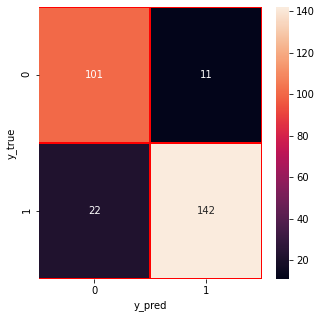

In [69]:
# confusion matrix visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,y_pred)
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

From above confusion matrix, we clearly learn that FP=20, FN=16

<a id='sect5-3'></a>
### <font color='darkgreen'>Area Under Curve (AUC)</font>
AUC is the area under the Receiver Operating Characteristic (ROC) curve (in orange) which maps the False Positive Rate vs. True Positive Rate, or the tradeoff between TP and FP. Ideally, you want as many True Positives as possible, and therefore for the ROC curve to hug to the y-axis and the area underneath it to be as large as possible.

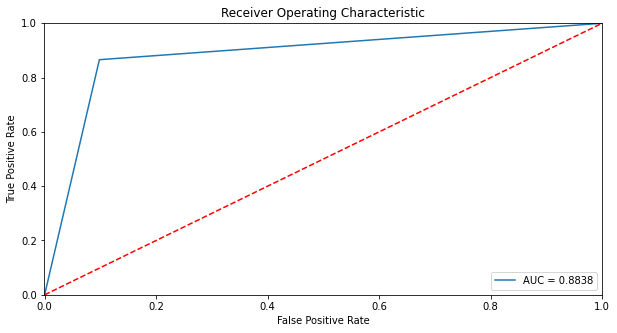

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

<a id='sect5-4'></a>
### <font color='darkgreen'>PR Curve</font>
A precision-recall curve (or PR Curve) is a plot of the precision (y-axis) and the recall (x-axis) for different probability thresholds. Precision-recall curves (PR curves) are recommended for highly skewed domains where ROC curves may provide an excessively optimistic view of the performance.

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.95')

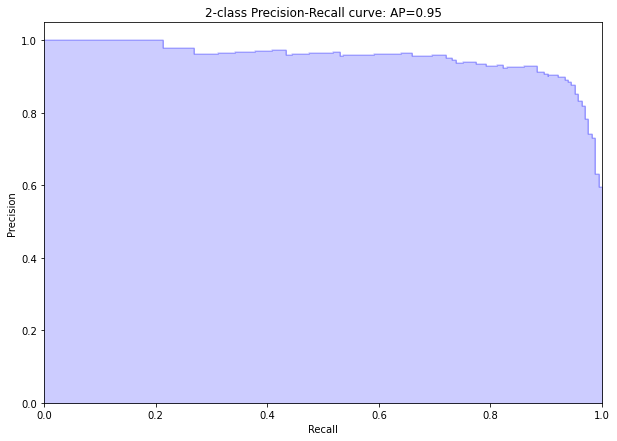

In [71]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score_rf = pipe.predict_proba(X_test)[:,-1]
average_precision = average_precision_score(y_test, y_score_rf)
precision, recall, _ = precision_recall_curve(y_test, y_score_rf)

fig, ax = plt.subplots(figsize=(10, 7)) 
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

Precision and recall are trade-off you have to make decision to favor one of them if the model is not perfect. e.g.:
* For **rare cancer/fraud data modeling**, anything that doesn't account for false-negatives is a crime. **Recall** is a better measure than precision. (寧可錯殺, 不可放過)
* For **YouTube recommendations**, false-negatives is less of a concern. **Precision** is better here. (做對無賞, 猜錯有罰)

## <font color='darkblue'>Conclusion</font>
Up to this point, we have developed model to classifiy heart disease cases and:
* First, we made the detailed exploratory analysis.
* We have decided which metric to use.
* We analyzed both target and features in detail.
* We transform categorical variables into numeric so we can use them in the model.
* We use pipeline to avoid data leakage.
* We looked at the results of the each model and selected the best one for the problem on hand.
* We looked in detail Catboost
* We made hyperparameter tuning of the Catboost with Optuna to see the improvement
* We looked at the feature importance.

## <font color='darkblue'>Supplement</font>
* <a href='https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/'>Dealing With Missing Values in Python – A Complete Guide</a>
* <a href='https://www.analyticsvidhya.com/blog/2017/03/imbalanced-data-classification/'>Imbalanced Data : How to handle Imbalanced Classification Problems</a>
* <a href='https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15'>Medium - What is Exploratory Data Analysis?</a>
* [Medium - Fundamental Techniques of Feature Engineering for Machine Learning](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114)
* [Kaggle - Feature engineering](https://www.kaggle.com/learn/feature-engineering)
* [Step by Step process of Feature Engineering for Machine Learning Algorithms in Data Science](https://www.analyticsvidhya.com/blog/2021/03/step-by-step-process-of-feature-engineering-for-machine-learning-algorithms-in-data-science/)
* [Medium - Strategies for working with discrete, categorical data](https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63)
* [Medium - All about Categorical Variable Encoding](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02) ([notebook](https://nbviewer.org/github/johnklee/ml_articles/blob/master/medium/All_about_Categorical_Variable_Encoding/notebook.ipynb))
* [Medium - Various ways to evaluate a machine learning model’s performance](https://towardsdatascience.com/various-ways-to-evaluate-a-machine-learning-models-performance-230449055f15)
* [11 Important Model Evaluation Metrics for Machine Learning Everyone should know](https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/)
* [Kaggle - Calculating and Plotting AUC Score](https://www.kaggle.com/antmarakis/calculating-and-plotting-auc-score)
* [MLM - ROC Curves and Precision-Recall Curves for Imbalanced Classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)
* [Precision vs. Recall – An Intuitive Guide for Every Machine Learning Person](https://www.analyticsvidhya.com/blog/2020/09/precision-recall-machine-learning/)